## Setup

- Working directory: Project Root Directory
- Required Packages: google-cloud-storage

In [1]:
!pip install google-cloud-storage

In [15]:
import json

from pathlib import Path
from google.cloud import storage
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from tqdm.contrib.concurrent import thread_map

In [125]:
# Settings

DATASETS = ["diagrams_wo_text", "diagrams"]
BUCKET_NAME = "digital_ink_diagram_data"
MAX_WORKERS = 8
PREPROC_DIR = 'didi_dataset'
SPLITS = {'test': 'test', 'train': 'train', 'valid': 'val'}

In [126]:
# Helper settings

def json_file(dataset):
    return f'{PREPROC_DIR}/{dataset}_20200131.ndjson'

def data_dir(dataset):
    return f'data/didi_{dataset}'

### Setup


- Setup scratch space to download files
- Download ndjson and the xdot files
- Setup images, and labels folders
- Parse ndjson and xdot
    - Split into test, train, and val
    - Collect various categories from the xdot file
    - Print input images
    - Approximate bounding boxes for shapes
    - Approximate bounding boxes for arrows
    - Filter examples where there is no overlap between bounding boxes and the strokes

In [127]:
def create_dirs():
    # Post processed data
    for dataset in DATASETS:
        ddir = data_dir(dataset)
        for split in SPLITS.values():
            Path(ddir, split, 'images').mkdir(parents=True)
            Path(ddir, split, 'labels').mkdir(parents=True)

def download_blob(blob):
    blob.download_to_filename(str(Path(PREPROC_DIR, blob.name)))
    
def download_all():
    # Data already downloaded
    if Path(PREPROC_DIR, 'xdot').exists():
        return
    
    # Google cloud bucket
    Path(PREPROC_DIR, 'xdot').mkdir(parents=True, exist_ok=True)
    
    # Google Storage Client
    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name=BUCKET_NAME)
    
    # Download ndjson and xdot files
    validext = lambda bname: bname.endswith('.ndjson') or bname.endswith('.xdot')
    blobs = [blob for blob in bucket.list_blobs() if validext(blob.name)]
    
    thread_map(download_blob, blobs, max_workers=MAX_WORKERS)

In [138]:
# TODO: Check data directory existence

create_dirs()
download_all()

In [111]:
# Collect shapes from all xdot files

import os
import pydot

shapes = set(['arrow'])

for _, _, files in os.walk(Path(PREPROC_DIR, 'xdot')):
    for file in files:
        graph = pydot.graph_from_dot_file(Path(PREPROC_DIR, 'xdot', file))[0]
        for node in graph.get_nodes():
            shape = node.get_shape()
            if shape is not None and shape not in shapes:
                shapes.add(shape)
                
shapes

{'arrow', 'box', 'diamond', 'octagon', 'oval', 'parallelogram'}

In [129]:
## Hardcode list of shapes

shapes = ['arrow', 'box', 'diamond', 'octagon', 'oval', 'parallelogram']
inv_shapes = {shape: i for i, shape in enumerate(shapes)}

In [139]:
# Print the hardcoded list to classes.txt
def save_shapes():
    for dataset in DATASETS:
        with open(Path(data_dir(dataset), 'classes.txt'), 'w') as file:
            for line in shapes:
                file.write(f'{line}\n')

In [140]:
save_shapes()

In [151]:
# Displays prompt images with drawing overlaid.

import pydot

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from tqdm import tqdm


def PrepareDrawing():
    plt.clf()
    plt.axes().set_aspect("equal")
    plt.gca().yaxis.set_visible(False)
    plt.gca().xaxis.set_visible(False)
    plt.gca().axis('off')
    plt.gca().invert_yaxis()
    
    
def get_drawing_bb(ink):
    minx = 99999
    miny = 99999
    maxx = 0
    maxy = 0

    for s in ink['drawing']:
        minx = min(minx, min(s[0]))
        maxx = max(maxx, max(s[0]))
        miny = min(miny, min(s[1]))
        maxy = max(maxy, max(s[1]))
    return (minx, miny, maxx - minx, maxy - miny)
    
    
def bbox_disjoint(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    
    # b1 left edge to right of b2 right edge
    # b1 right edge to left of b2 left edge
    # b1 bottom edge to top of b2 top edge
    # b1 top edge to bottom of b2 bottom edge
    return x1 > x2 + w2 or x1 + w1 < x2 or y1 > y2 + h2 or y1 + h1 < y2

    
def approx_bb(ddir, ink, print_bbox=False):
    # Compute scaling of the image.
    guide_width = ink["writing_guide"]["width"]
    guide_height = ink["writing_guide"]["height"]
    
    # Graph
    graph = pydot.graph_from_dot_file(str(Path(PREPROC_DIR, 'xdot', ink['label_id']).with_suffix('.xdot')))[0]
    bb = [float(coord) for coord in graph.get_bb().strip('"').split(',')]
    im_width, im_height = bb[2] - bb[0], bb[3] - bb[1]
    
    # Compute offsets
    scale=min(guide_width / im_width, guide_height / im_height)
    offset_x = (guide_width - scale * im_width) / 2
    offset_y = (guide_height - scale * im_height) / 2
    
    # Collect bboxes for each shape and arrow
    bboxes = []
    src_bbox = get_drawing_bb(ink)
    
    for node in graph.get_nodes():
        shape = node.get_shape()
        if shape is None:
            continue

        pos = [float(coord) for coord in node.get_pos().strip('"').replace('\\\n', '').split(',')]
        cw = offset_x + scale * pos[0]
        ch = offset_y + scale * (im_height - pos[1])
        bbscale = 75
        bbw, bbh = float(node.get_width()) * bbscale * scale, float(node.get_height()) * bbscale * scale
        minw, minh = cw - bbw/2, ch - bbh/2
        # Check if bbox includes some stroke (only an approximation)
        if bbox_disjoint(src_bbox, (minw, minh, bbw, bbh)):
            return False
        bboxes.append([inv_shapes[shape], minw, minh, bbw, bbh])
        if print_bbox:
            rectangle = patches.Rectangle((cw - bbw/2, ch - bbh/2), bbw, bbh, 
                             linewidth=1, edgecolor='b', facecolor='none')
            plt.gca().add_patch(rectangle)
    
    for edge in graph.get_edges():
        # Edge
        pos = edge.get_pos()
        if pos is None:
            continue

        pos = [[float(feat) for feat in coord.split(',')] for coord in pos.strip('"').replace('\\\n', '').lstrip('e,').split(' ')]
        ws, hs = [coord[0] for coord in pos], [coord[1] for coord in pos]
        minw, maxw = offset_x + scale * min(ws), offset_x + scale * max(ws)
        minh, maxh = offset_y + scale * (im_height - max(hs)), offset_y + scale * (im_height - min(hs))
        # Ensure minimum width, weight (10 * scale)
        if maxw - minw < 10 * scale:
            minw -= 5 * scale
            maxw += 5 * scale
        if maxh - minh < 10 * scale:
            minh -= 5 * scale
            maxh += 5 * scale
        bbw, bbh = maxw - minw, maxh - minh
        if bbox_disjoint(src_bbox, (minw, minh, bbw, bbh)):
            return False
        bboxes.append([inv_shapes['arrow'], minw, minh, bbw, bbh])
        if print_bbox:
            rectangle = patches.Rectangle((minw, minh), bbw, bbh, 
                             linewidth=1, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rectangle)
            
    # Save these bboxes to a file
    with open(Path(ddir, 'labels', ink['label_id']).with_suffix('.txt'), 'w') as file:
        for bbox in bboxes:
            file.write(' '.join([str(label) for label in bbox]) + '\n')
            
    return True

    
def display_strokes(ink):
    for s in ink["drawing"]:
        plt.plot(s[0], [y for y in s[1]], color="black")

        
def display_ink(ddir, ink):
    # Draw image, overlay strokes.
    PrepareDrawing()
    display_strokes(ink)
    scheck = approx_bb(ddir, ink, print_bbox=True)
    if not scheck:
        # Do not print. Ignore this figure.
        return
    canvas = FigureCanvas(plt.gcf())
    canvas.print_figure(str(Path(ddir, 'images', ink['label_id']).with_suffix('.png')), bbox_inches='tight')


def parse_drawings():
    for dataset in DATASETS:
        ddir = data_dir(dataset)
        
        # Collect only the relevant drawings
        drawings = []
        ink_set = set()
        with open(json_file(dataset), 'r') as file:
            for line in file:
                ink = json.loads(line)
                label_id = ink['label_id']
                if label_id in ink_set:
                    continue
                ink_set.add(label_id)
                
                drawings.append(ink)
        
        # Now iterate over drawings to
        # - print strokes
        # - approx bb
        for ink in tqdm(drawings):
            split = SPLITS[ink['split']]
            display_ink(f'{ddir}/{split}', ink)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5629/5629 [05:17<00:00, 17.74it/s]


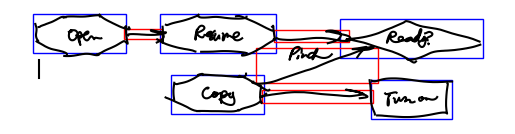

In [152]:
parse_drawings()